# Tree based methods

Trees construct prediction models from data. They recursively partition the data space to fit a boolean prediction model within each partition. The result is represented graphically as a decision tree. Trees can be used for regression of classification.

When the number of features, $p$, is large interpretability is easier than in distance based methods or probabilistic classification, where boundaries are much more difficult to be explained in higer dimensions.

## Regression Example

We will start by building a simple regression example with the [wholesale customer dataset in UCI](https://archive.ics.uci.edu/ml/datasets/wholesale+customers). It contains 440 samples of 8 variables, and we will try to build a model that will help us to predict the annual spending on fresh products (first variable) with a regression tree.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz

%matplotlib inline

In [2]:
class Split:
    """
    This class represents a split from a dataset, it will assign
    each dataframe partition passed as argument to a different 
    attribute of the class: 'train', 'test' (and 'validation').
    The class method 'split' performs the splitting of the dataframe
    passed, according to the parameters passed.
    
    Example:
    
        X, Y = Split.split(my_data, my_target)
        
    """
    split_name = ['train', 'test', 'validation']
    
    def __init__(self, splits):
        for index, partition in enumerate(splits):
            setattr(self, self.split_name[index], partition)

    @classmethod
    def split(cls,
              data, 
              target, 
              seed=1024, 
              test_size=0.2, 
              validation_split=False):
        """
        From an input dataframe, separate features from target, and 
        produce splits (with or without validation).
        """
        features = list(data)
        features.remove(target)
        X = pd.DataFrame(data, columns=features)
        Y = pd.DataFrame(data.loc[:, target])

        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, 
            test_size=test_size, random_state=seed)

        if validation_split is True:
            X_train, X_val, Y_train, Y_val = train_test_split(
                X_train, Y_train, 
                test_size=test_size, random_state=seed)
            X_splits = [X_train, X_test, X_val]
            Y_splits = [Y_train, Y_test, Y_val]
        else:
            X_splits = [X_train, X_test]
            Y_splits = [Y_train, Y_test]

        return Split(X_splits), Split(Y_splits)

In [3]:
class Dataset:
    """
    This class allows a simpler representation of the dataset used
    to build a model in class. It allows loading a remote CSV by
    providing an URL to the initialization method of the object.

        my_data = Dataset(URL)
        
    """
    def __init__(self, data_location):
        self.data = pd.read_csv(data_location)
        
    def target(self, target):
        self.features = list(self.data)
        self.features.remove(target)
        self.target = target


In [4]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
wholesale = Dataset(data_url)
wholesale.target('Fresh')
X, Y = Split.split(wholesale.data, wholesale.target)

In [5]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=3)
regressor.fit(X.train, Y.train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

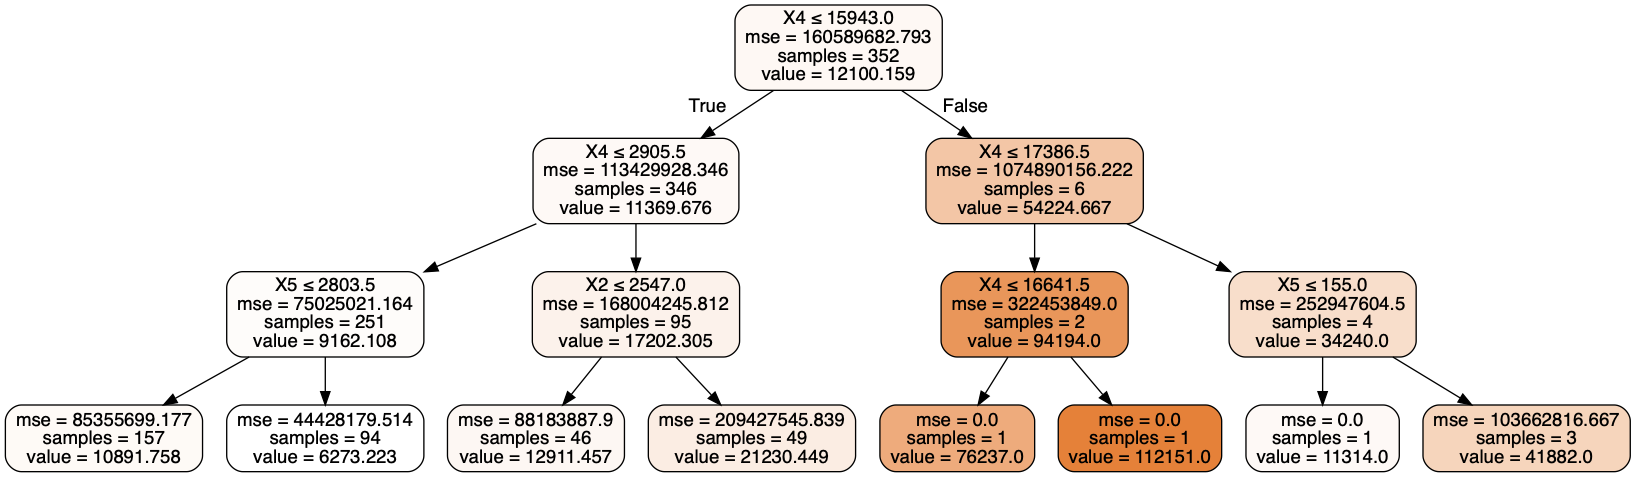

In [6]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(regressor, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

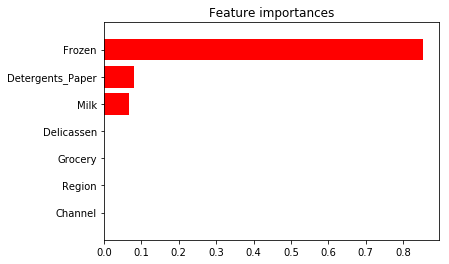

In [7]:
importances = regressor.feature_importances_
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.train.shape[1]), importances[indices],
       color="r", align="center")

index_names = [list(X.train)[i] for i in indices]

plt.yticks(range(X.train.shape[1]), index_names)
plt.ylim([-1, X.train.shape[1]])
plt.show()

Understanding the tree structure (partially from [here](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py))

In [11]:
n_nodes = regressor.tree_.node_count
children_left = regressor.tree_.children_left
children_right = regressor.tree_.children_right
feature = regressor.tree_.feature
threshold = regressor.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.
node_indicator = regressor.decision_path(X.test)

# Similarly, we can also have the leaves ids reached by each sample.
leave_id = regressor.apply(X.test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.
sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

The binary tree structure has 15 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 4] <= 15943.0 else to node 8.
	node=1 test node: go to node 2 if X[:, 4] <= 2905.5 else to node 5.
		node=2 test node: go to node 3 if X[:, 5] <= 2803.5 else to node 4.
			node=3 leaf node.
			node=4 leaf node.
		node=5 test node: go to node 6 if X[:, 2] <= 2547.0 else to node 7.
			node=6 leaf node.
			node=7 leaf node.
	node=8 test node: go to node 9 if X[:, 4] <= 17386.5 else to node 12.
		node=9 test node: go to node 10 if X[:, 4] <= 16641.5 else to node 11.
			node=10 leaf node.
			node=11 leaf node.
		node=12 test node: go to node 13 if X[:, 5] <= 155.0 else to node 14.
			node=13 leaf node.
			node=14 leaf node.



What's the MSE of this tree when making predictions?